# <a name="setup_section"></a> 1. Setup: Manage Installations Imports and Helper Functions


In [1]:
#!pip install --upgrade GPy
#!pip install --upgrade numpy

In [2]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import csv
import GPy
import numpy as np

from datetime import datetime
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import norm, percentileofscore

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


# <a name="loading_datasets"></a> 2. Loading Datasets


## Load metadata


In [3]:
metdata_path = "..\\data\\metadata\\"
metadata = pd.read_csv(metdata_path + "metadata.csv")


## Load weather data

In [4]:
# Weather data
weather_path = "..\\data\\weather\\"
weather = pd.read_csv(weather_path + "weather.csv")

In [5]:
weather.head()

,timestamp,site_id,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed
0,2016-01-01 00:00:00,Panther,19.4,NaN,19.4,0.0,NaN,NaN,0.0,0.0
1,2016-01-01 01:00:00,Panther,21.1,6.0,21.1,-1.0,NaN,1019.4,0.0,0.0
2,2016-01-01 02:00:00,Panther,21.1,NaN,21.1,0.0,NaN,1018.8,210.0,1.5
3,2016-01-01 03:00:00,Panther,20.6,NaN,20.0,0.0,NaN,1018.1,0.0,0.0
4,2016-01-01 04:00:00,Panther,21.1,NaN,20.6,0.0,NaN,1019.0,290.0,1.5



## Load raw dataset

In [6]:
raw_meters_path = "..\\data\\meters\\raw\\"

# files in directory
files = glob(raw_meters_path + "*.csv")

In [7]:

dfs = [] # empty list of the dataframes to create
for file in files: # for each file in directory
    meter_type = file.split("\\")[4].split(".")[0] # meter_type to rename the value feature
    meter = pd.read_csv(file) # load the dataset
    meter = pd.melt(meter, id_vars = "timestamp", var_name = "building_id", value_name = "meter_reading") # melt dataset
    meter["meter"] = str(meter_type) # adds column with the meter type
    dfs.append(meter) # append to list
raw_data_cleaned = pd.concat(dfs, axis=0, ignore_index=True) # concatenate all meter
del(dfs, meter, file, files, meter_type)

raw_data_cleaned.head()


,timestamp,building_id,meter_reading,meter
0,2016-01-01 00:00:00,Panther_office_Clementine,NaN,chilledwater
1,2016-01-01 01:00:00,Panther_office_Clementine,NaN,chilledwater
2,2016-01-01 02:00:00,Panther_office_Clementine,NaN,chilledwater
3,2016-01-01 03:00:00,Panther_office_Clementine,NaN,chilledwater
4,2016-01-01 04:00:00,Panther_office_Clementine,NaN,chilledwater


## Load cleaned dataset


In [8]:
cleaned_meters_path = "..\\data\\meters\\cleaned\\"

# files in directory
files = glob(cleaned_meters_path + "*.csv")


In [9]:
dfs = [] # empty list of the dataframes to create
for file in files: # for each file in directory
    meter_type = file.split("\\")[4].split(".")[0] # meter_type to rename the value feature
    meter = pd.read_csv(file) # load the dataset
    meter = pd.melt(meter, id_vars = "timestamp", var_name = "building_id", value_name = "meter_reading") # melt dataset
    meter["meter"] = str(meter_type) # adds column with the meter type
    dfs.append(meter) # append to list
complete_data_cleaned = pd.concat(dfs, axis=0, ignore_index=True) # concatenate all meter
del(dfs, meter, file, files, meter_type)

complete_data_cleaned.head()


,timestamp,building_id,meter_reading,meter
0,2016-01-01 00:00:00,Panther_office_Clementine,NaN,chilledwater_cleaned
1,2016-01-01 01:00:00,Panther_office_Clementine,NaN,chilledwater_cleaned
2,2016-01-01 02:00:00,Panther_office_Clementine,NaN,chilledwater_cleaned
3,2016-01-01 03:00:00,Panther_office_Clementine,NaN,chilledwater_cleaned
4,2016-01-01 04:00:00,Panther_office_Clementine,NaN,chilledwater_cleaned


In [10]:
# Note this cell might take some time to finish

# Convert timestamp field from string into pd.datetime object
complete_data_cleaned['timestamp'] = pd.to_datetime(complete_data_cleaned['timestamp'])

# Add column indicating the year, month and dayOfTheWeek for that timestamp
complete_data_cleaned['date'] = complete_data_cleaned['timestamp'].dt.date
complete_data_cleaned['year'] = complete_data_cleaned['timestamp'].dt.year
complete_data_cleaned['month'] = complete_data_cleaned['timestamp'].dt.month
complete_data_cleaned['dayOfWekk'] = complete_data_cleaned['timestamp'].dt.dayofweek


# Load benchmarks


In [11]:
cleaned_meters_path = "..\\data\\"

# files in directory
files = glob(cleaned_meters_path + "*.csv")


benchmark = pd.read_csv(files[0]) # load the dataset

benchmark

,name,building_id,RMSE,MAE,horizon
0,Bear_utility_Sidney,utility,1.157131,0.846614,hourly
1,Bear_utility_Sidney,utility,1.255013,0.862390,daily
2,Bear_utility_Sidney,utility,1.851878,1.167219,weekly
3,Cockatoo_religion_Diedre,religion,1.475301,1.018945,hourly
4,Cockatoo_religion_Diedre,religion,2.349360,1.820794,daily
5,Cockatoo_religion_Diedre,religion,2.833513,1.958076,weekly
6,Cockatoo_science_Rex,science,7.304536,5.529282,hourly
7,Cockatoo_science_Rex,science,10.882962,7.975783,daily
8,Cockatoo_science_Rex,science,12.667458,8.261340,weekly
9,Eagle_education_Teresa,education,8.286079,5.855556,hourly


# Gaussian Process Regression

## Implement Helper Functions

In [12]:
"""
Normalizes the data to a Gaussian distribution using quantiles.
"""
def normalizeToGaussian(arr, mode="mean"):
    n = len(arr)
    perc = percentileofscore
    arr_ = arr.copy()[~np.isnan(arr)]
    out = np.zeros(n)
    for i in range(n):
        if not np.isnan(arr[i]):
            out[i] = norm.ppf(perc(arr_, arr[i], mode) / 100.)
        else:
            out[i] = np.nan
    return out


In [13]:
'''
Replaces missing values in the dataframe with the mean of the month for all years from which we have data
@param dataframe
@returns numpy array
'''
def averageNaNs (df, field):
    mean_df = df.groupby(['month']).mean()
    averaged_mean = df[field].copy().fillna(df['month'].map({1: mean_df[field][1] , 2: mean_df[field][2], 3:mean_df[field][3],
                                                    4: mean_df[field][4] , 5: mean_df[field][5], 6:mean_df[field][6], 
                                                    7: mean_df[field][7] , 8: mean_df[field][8], 9:mean_df[field][9],
                                                    10: mean_df[field][10] , 11: mean_df[field][11], 12:mean_df[field][12]}))
    
    averaged_numpy = averaged_mean.to_numpy()
    return averaged_numpy

In [14]:
'''
Train a Gaussian Process model based on the training data
@param two numpy arrays of same dimensionality
@returns numpy array with lenght NUMBER_OF_DIMENSIONS, containing the indices of the most correlated stations
'''
def trainGP (X_train, Y_train):
    
    # Shape of training data needs to be consistent 
    assert X_train.shape[0] == Y_train.shape[0]
    
    kernel = GPy.kern.RBF(input_dim=X_train.shape[1])
    model = GPy.models.GPRegression(X_train, Y_train, kernel)
    model.optimize(messages=True)
    model.optimize_restarts(num_restarts=10)
    
    return model

# So far unused helper functions

In [15]:
'''
Computation of Spearmas Rank Correlation
@param  target_df: a pandas.dataframe (target) for wich we want to calculate the correlation matrix 
        dataset: a list of pandas dataframes that build our base, as we check for the correlation between dataframe and each df in the truncated dataset
@returns spearmans_matrix: a numpy.ndarray that contains the correlation value as first entry in each row and the corresponding p-value as a second element in each row. 
                            the order of stations in the matrix is consistent to the order in the dataset:
'''
def spearmansCorrelation (target_df, truncated_dataset): 
    spearmans_matrix = np.zeros((len(truncated_dataset), 2))
    for index, df in enumerate(truncated_dataset): 
        if (target_df.shape[0]!= df.shape[0]) or (df['MEAN'].isnull().all()):
            spearmans_matrix[index] = 0,100 
            continue
        else: 
            correlation, pval = stats.spearmanr(target_df['MEAN'], df['MEAN'], nan_policy='omit')
            spearmans_matrix[index] = correlation,pval    
            
    return spearmans_matrix

In [16]:
'''
Based on a dataframe for which we want to fill missing values we select the most correlated timeseries of our prediction base
Then we transform and truncate the time series so that we get input output mappings for training, and sets of input timeseries
for the time before and after the active timespan of our dataframe for which we want to infer missing data.
@param pandas.dataframe (target timeseries), list of pandas.dataframes (predictionBase), numpy.array (indices)
@returns multiple numpy arrays with training and test data, and the dates for the timesegments for training and prediction
'''
def getDataForTrainingAndPredicting (dataframe, prediction_base, indices): 
    
    X_train  = []
    X_test   = []
    X_before = []
    X_after  = []
    
    dim = indices.size
    start = dataframe['date'].iloc[0]
    end = dataframe['date'].iloc[-1]
    
    mostCorrelatedTimeseries = [prediction_base[index] for index in indices]
    
    splitind_df = int(dataframe.shape[0] * TRAIN_TEST_THRESHOLD)
   
    startind = max(0, mostCorrelatedTimeseries[0].loc[mostCorrelatedTimeseries[0]['date'] == start].index.values[0])
    splitind = startind + splitind_df 
    endind = min(mostCorrelatedTimeseries[0].shape[0] -1, mostCorrelatedTimeseries[0].loc[mostCorrelatedTimeseries[0]['date'] == end].index.values[0])
    
    
    datesBefore = mostCorrelatedTimeseries[0]['date'][:startind]
    datesTrain = mostCorrelatedTimeseries[0]['date'][startind :splitind]
    datesTest = mostCorrelatedTimeseries[0]['date'][splitind : endind]
    datesAfter = mostCorrelatedTimeseries[0]['date'][endind :]

    for ts in mostCorrelatedTimeseries: 
        tsNormalized = normalizeToGaussian(ts['MEAN'].copy().to_numpy())
        x_train = tsNormalized[startind: splitind].copy()
        
        x = normalizeToGaussian(averageNaNs(ts)).reshape(-1,1)
        x_before = x[:startind].copy()
        x_after = x[endind:].copy()
        x_test = x[splitind: endind].copy()
        
        X_train.append(x_train)
        X_test.append(x_test)
        X_before.append(x_before)
        X_after.append(x_after)

    X_test = np.column_stack((X_test))
    X_train = np.column_stack((X_train))
    X_before = np.column_stack((X_before))
    X_after = np.column_stack((X_after))
    
    Y_test = normalizeToGaussian(averageNaNs(dataframe))[splitind_df:].copy().reshape(-1,1)    
    Y_train  = normalizeToGaussian(dataframe['MEAN'].copy().to_numpy())[:splitind_df].reshape(-1,1) 

    train = np.concatenate((X_train,Y_train), axis=1)
    train_clean = train.copy()[~np.isnan(train).any(axis=1)]
    Y_train = train_clean[:,-1].reshape(-1,1)
    X_train = train_clean[:,:dim]

    return  X_before, X_after, X_train, X_test, Y_train, Y_test, datesBefore, datesTrain, datesTest, datesAfter

### Load dataframe

In [18]:
# Convert timestamp field from string into pd.datetime object
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

# Add column indicating the year, month and dayOfTheWeek for that timestamp
weather['date'] = weather['timestamp'].dt.date
weather['month'] = weather['timestamp'].dt.month

In [19]:
# Convert timestamp field from string into pd.datetime object
#complete_data_cleaned['timestamp'] = pd.to_datetime(complete_data_cleaned['timestamp'])

# Add column indicating the year, month and dayOfTheWeek for that timestamp
#complete_data_cleaned['date'] = pd.to_datetime(complete_data_cleaned['timestamp']).dt.date
#complete_data_cleaned['year'] = pd.to_datetime(complete_data_cleaned['timestamp']).dt.year
#complete_data_cleaned['month'] = pd.to_datetime(complete_data_cleaned['timestamp']).dt.month
complete_data_cleaned['dayOfWeek'] = complete_data_cleaned['timestamp'].dt.dayofweek


In [20]:
bear_sidney = complete_data_cleaned.loc[complete_data_cleaned['building_id']  == 'Bear_utility_Sidney']
bear_sidney_meta = metadata.loc[metadata['building_id'] == 'Bear_utility_Sidney']
bear_weather = weather.loc[weather['site_id'] == 'Bear']

### Transform into Gaussian

In [21]:
bear_sidney_gauss = normalizeToGaussian(averageNaNs(bear_sidney, 'meter_reading'))

In [22]:
bear_sidney_weather_air_temp = normalizeToGaussian(averageNaNs(bear_weather,'airTemperature'))
bear_sidney_weather_dew_temp = normalizeToGaussian(averageNaNs(bear_weather,'dewTemperature'))
bear_sidney_weather_precip_1HR = normalizeToGaussian(averageNaNs(bear_weather,'precipDepth1HR'))

In [23]:
train_meter, test_meter = train_test_split(bear_sidney_gauss, test_size=0.3, shuffle=False)
train_weather_air_temp, test_weather_air_temp = train_test_split(bear_sidney_weather_air_temp, test_size=0.3, shuffle=False)
train_weather_dew_temp, test_weather_dew_temp = train_test_split(bear_sidney_weather_dew_temp, test_size=0.3, shuffle=False)
train_weather_precip_1HR, test_weather_precip_1HR = train_test_split(bear_sidney_weather_precip_1HR, test_size=0.3, shuffle=False)

In [24]:
X_train = np.column_stack(([train_weather_air_temp, train_weather_dew_temp, train_weather_precip_1HR]))
X_test = np.column_stack(([test_weather_air_temp, test_weather_dew_temp, test_weather_precip_1HR]))

In [25]:
X_train.shape[0] == train_meter[0:-1].shape[0]

True

In [27]:
# Define the kernel for the Gaussian process
kernel = GPy.kern.RBF(input_dim=X_train.shape[1])  # Radial basis function (RBF) kernel

 ^ Current cell ^ 

In [59]:
# Create a Gaussian process regression model
model = GPy.models.GPRegression(X_train[-3000:], train_meter[-3000:].reshape(-1,1), kernel)

In [61]:
# Optimize the model parameters
model.optimize(messages=True)

In [65]:

# Make predictions with the trained model
mean, var = model.predict(X_test[0:200])

# Access other information about the model
print("model", model)


model 
Name : GP regression
Objective : 4216.46764308489
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |  0.3065504262887989  |      +ve      |        
  rbf.lengthscale          |  0.7358513004143725  |      +ve      |        
  Gaussian_noise.variance  |  0.9392386420411227  |      +ve      |        


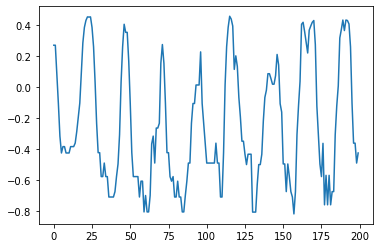

In [67]:
plt.plot(mean)

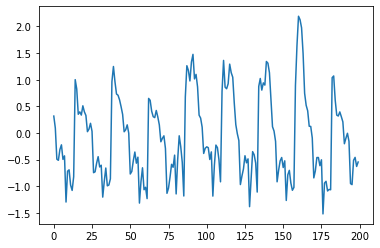

In [68]:
plt.plot(test_meter[0:200])

In [70]:
np.sqrt(mean_squared_error(test_meter[0:200], mean))

0.7592686272801239

In [ ]:
# Make predictions with the trained model
mean, var = model.predict(X_test)